<a href="https://colab.research.google.com/github/andreabenevenut/LLM_workshop/blob/main/notebooks/2_Parsing_structured_information_via_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Output Parsers



One of the compelling use cases that demonstrate the power of Large Language Models is their capability to extract pertinent information from text and subsequently parse it into structured formats.

Textual data comes in various forms: articles, research papers, social media posts, and more—often containing critical insights that are buried within the unstructured content. Extracting this information manually can be time-consuming and error-prone. Here's where Large Language Models equipped with natural language understanding and processing capabilities can play an important role.

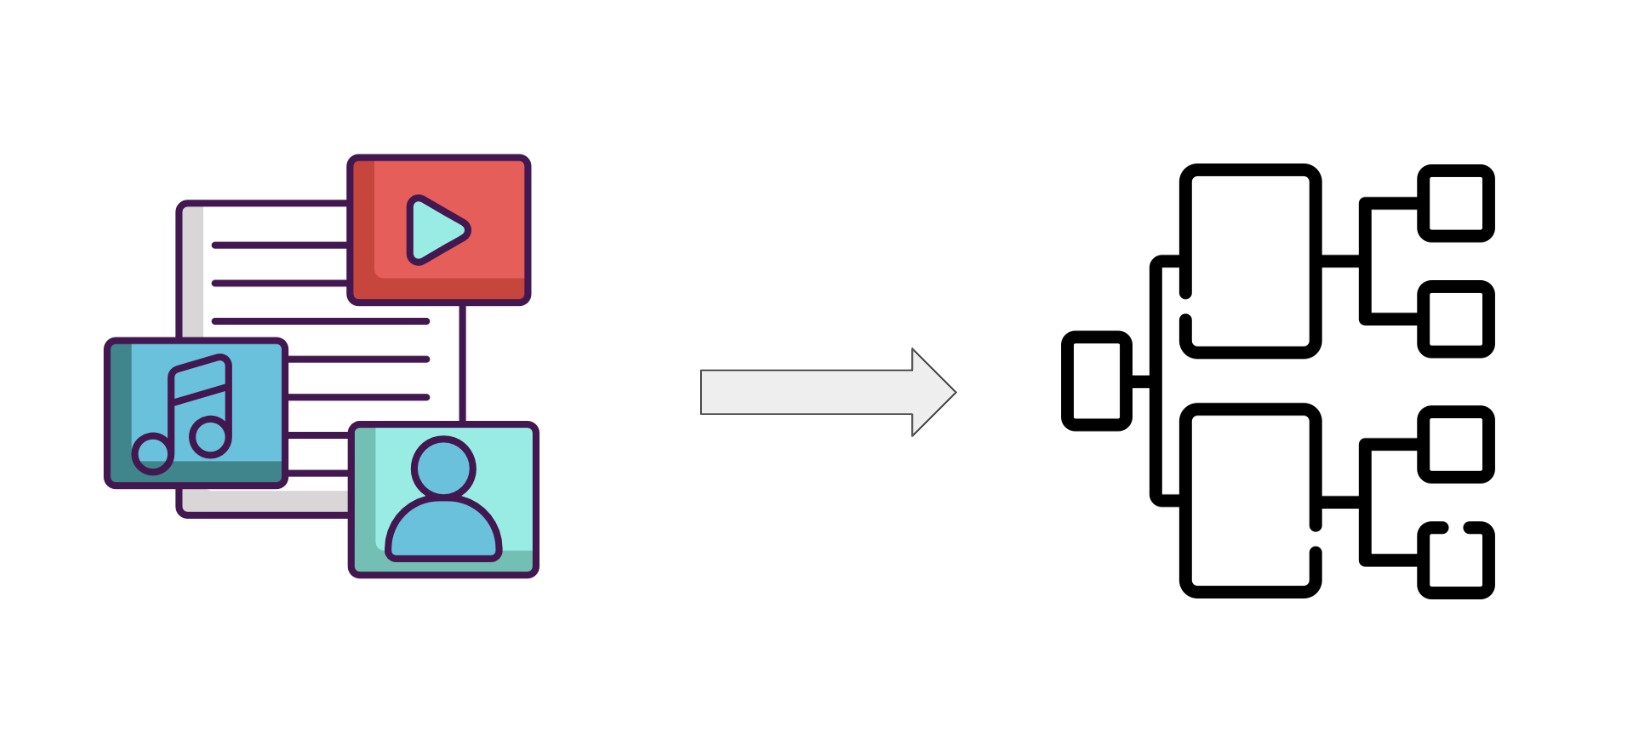

# 0: SET UP

In [ ]:
!git clone https://github.com/datarootsio/LLMs_workshop.git

In [ ]:
!pip install -r "/content/LLMs_workshop/requirements.txt"

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""

In [ ]:
MODEL_NAME = "gpt-3.5-turbo-1106"

# 1: Output Parsers

## JSON

Suppose that we have a piece of text and we want to extract information from it in a specific format, for example JSON.

To reach our goal, we can make use of LangChain, the OpenAI API and a desired ouput schema.

In [ ]:
from langchain.chains import create_extraction_chain
from langchain.chat_models import ChatOpenAI
import pandas as pd

In [ ]:
sample_text = """
  Alex (25 years old) is 1.83 meters tall and loves playing basketball.
  He comes from Orlando and has quite a big family (5 siblings).
  He has a red Audi and works in the financial sector.

  His friend, Claudia, is one year younger than him and has the passion for travelling.
  She has a dog named Nellie and owns a green BMW. Claudia is very outgoing, sporty and has a good sense of humor.

  Ben, Claudia's dad, is 63 and is into peotry and music.
  His sophisticated silver Volvo S90 gleams in the driveway, reflecting his appreciation for elegance and refinement.
  Ben worked as a librarian for almost 40 years at the local school in town.
  """

In [ ]:
# LLM
llm = ChatOpenAI(temperature=0, model=MODEL_NAME)

In [ ]:
# Schema
schema = {
    "properties": {
        "name": {"type": "string"},
        "hobby": {"type": "string"},
        "age": {"type": "integer"},
    },
    "required": ["name", "hobby", "age"],
}

# Extraction chain
json_extraction_chain = create_extraction_chain(schema, llm)

output = json_extraction_chain.run(sample_text)
output

In [ ]:
pd.DataFrame(output)

In [ ]:
json_extraction_chain.prompt

### Multiple entity types

It is also possible to define multiple entities and require our LLM to extract information about each entity separately. To do that, we can make use of prefixes that will indicate the entity name.

Suppose that we want to differentiate between people and cars.

We can add `person_` and `car_` prefixes for each property

In [ ]:
schema = {
    "properties": {
        "person_name": {"type": "string"},
        "person_hobby": {"type": "string"},
        "person_age": {"type": "integer"},
        "person_extra_info": {"type": "string"},
        "car_model": {"type": "string"},
        "car_color": {"type": "string"},
    }
}

json_extraction_chain = create_extraction_chain(schema, llm)

output = json_extraction_chain.run(sample_text)
output

In [ ]:
pd.DataFrame(output)

Notice that we can extract extra information about an entity, by adding the suffix `extra_info`!

## Pydantic


There is another possibility to define the schema, via Pydantic.

[Pydantic](https://docs.pydantic.dev/latest/) is a data validation and settings management library for Python.

It allows you to create data classes with attributes that are automatically validated when you instantiate an object.

Let's use the same example and define a class with attributes annotated with types.

In [ ]:
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain.pydantic_v1 import BaseModel

# Pydantic data class
class Properties(BaseModel):
    person_name: str
    person_hobby: List[str]
    person_age: int
    person_extra_info: str
    car_model: str
    car_color: str

# Extraction chain
pydantic_extraction_chain = create_extraction_chain_pydantic(pydantic_schema=Properties, llm=llm, verbose=True)

# Run
output = pydantic_extraction_chain.run(sample_text)
output

In [ ]:
pd.DataFrame([vars(obj) for obj in output])

# 2: Format instructions for a chain

We previously saw how to extract infomation from a piece of text and format it in a structured way.

We can also specify the desired output format in a custom prompt that we provide to the LLM. Therefore, parsing the ouput in a strctured way is not only limited to information extraction but can be extended to all use cases that involves LLMs (e.g. QA_source_retrieval, Summarization, Text Completion, ...).

This can be achieved via the use of:
- `PydanticOutputParser`: to define the schema
- `PromptTemplate`: to define the custom prompt
- `LLMChain`: chain that puts the LLM and the other object all together.

We can also add custom validation logic for each attribute that we define in a Pydantic class.

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

llm = ChatOpenAI(temperature=0, model=MODEL_NAME, max_tokens=3500)

my_prompt = PromptTemplate(
    input_variables = ["pet_description", "format_instructions"],
    template = """
    You are a wizard at inventing adorable and hilarious names for pets!
    Your talent lies in crafting names that are both charming and amusing.
    Take the pet's description below, enclosed by triple backticks, and use it as inspiration to create 4 awesome names for the pet.

    pet description: ```{pet_description}```

    After crafting the new pet names, rate their potential success on a scale of 1 to 10 based on how catchy and memorable they are!

    {format_instructions}
    """
)

pet_chain = LLMChain(llm=llm, prompt=my_prompt)


In [ ]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import Sequence


# Define your desired data structure.
class PetInfo(BaseModel):
    pet_name: str = Field(description="This is the name of the pet")
    score: int = Field(description="This is an integer score between 1-10")
    reasoning: str = Field(description="This is the reasons for the score")

    # Validate score field
    @validator('score')
    def check_score(cls, field):
        if field > 10 or field < 1:
            raise ValueError("Score is outside the range (1-10)")
        return field

    # Validate pet_name field (example: minimum length of 2 characters)
    @validator('pet_name')
    def check_pet_name_length(cls, value):
        if len(value) < 2:
            raise ValueError("Pet name should be at least 2 characters long")
        return value

    # Validate reasoning field (example: maximum length of 100 characters)
    @validator('reasoning')
    def check_reasoning_length(cls, value):
        if len(value) > 100:
            raise ValueError("Reasoning should be maximum 100 characters long")
        return value


class PetNames(BaseModel):
    pet_names: Sequence[PetInfo] = Field(..., description="The pet names")


# Set up a parser + inject instructions into the prompt template.
pydantic_parser = PydanticOutputParser(pydantic_object=PetNames)

format_instructions = pydantic_parser.get_format_instructions()

In [ ]:
answer = pet_chain({
    "pet_description": "My cat is 10 years old and becomes quite grumpy if I don't feed him. He sleeps a lot, has gray fur, and striking blue eyes.",
    "format_instructions": format_instructions})
output = answer['text']
parsed_output = pydantic_parser.parse(output)

In [ ]:
pd.DataFrame([dict(obj) for obj in parsed_output.pet_names])

# EXERCISE

At Dataroots, an epic showdown went down between two prized teams: DataFoots and RootsBall. The comments on how these teams rocked the match can be found at the following path: `content/LLM_workshop/data/football_game.txt`

Read the file content and extract the following infomation from the text:
- name of the player
- player role
- number of goals
- team (DataFoots, RootsBall)

Use LLMs, LangChain and ouput parsers to parse the information and create a pandas dataframe with the final result.